In [1]:
import pandas as pd
import collections
import os
import sys

### 1. Prepare paths and localisation

Ensure the project root is the working directory so that relative paths
and imports from the `src` package behave consistently with .py scripts.

In [2]:
if os.getcwd().endswith('notebooks'):
    os.chdir('..')
    print(f"Zmieniono katalog roboczy na: {os.getcwd()}")

if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

Zmieniono katalog roboczy na: d:\$projects\python\master_thesis


### 2. test

In [16]:
from src.visualization.visualize import load_results, get_citation_distribution, calculate_ks_metrics, plot_zipf_comparison, generate_report_pdf

In [7]:
# 1. Wczytanie danych referencyjnych (Empirycznych)

articles_df = pd.read_csv('data/interim/articles_with_score_df.csv')
reference_dist = collections.Counter(articles_df['n_citation'].astype(int))

In [8]:
# 2. Wczytanie wyników eksperymentu
results_df = load_results('data/processed/global_distributions.csv')

In [9]:
# 3. Analiza statystyczna (Dodanie metryk do DF)
results_df['dist_cit'] = results_df['distribution'].apply(get_citation_distribution)
results_df[['KS_Stat', 'P_Val']] = results_df.apply(
    lambda r: calculate_ks_metrics(r['dist_cit'], reference_dist), axis=1, result_type='expand'
)

In [10]:
# 4. Wyświetlenie "Najlepszych" konfiguracji (najbardziej zbliżone do rzeczywistości)
top_results = results_df.nsmallest(10, 'KS_Stat')
display(top_results[['settings', 'KS_Stat', 'P_Val']])

,settings,KS_Stat,P_Val
16,"{'N': 10, 'k': 10, 'pn': [0.0, 0.5, 0.5, 0.0]}",0.095748,0.012607
33,"{'N': 10, 'k': 10, 'pn': [0.25, 0.5, 0.25, 0.0]}",0.106385,0.004969
88,"{'N': 10, 'k': 25, 'pn': [0.33, 0.33, 0.33, 0.0]}",0.110795,0.000100
93,"{'N': 10, 'k': 25, 'pn': [0.5, 0.25, 0.25, 0.0]}",0.112085,0.000114
35,"{'N': 10, 'k': 10, 'pn': [0.33, 0.0, 0.33, 0.33]}",0.116299,0.001277
90,"{'N': 10, 'k': 25, 'pn': [0.5, 0.0, 0.25, 0.25]}",0.117778,0.000022
18,"{'N': 10, 'k': 10, 'pn': [0.0, 0.75, 0.25, 0.0]}",0.118218,0.001307
31,"{'N': 10, 'k': 10, 'pn': [0.25, 0.25, 0.5, 0.0]}",0.118329,0.000826
21,"{'N': 10, 'k': 10, 'pn': [0.0, 1.0, 0.0, 0.0]}",0.119258,0.001317
67,"{'N': 10, 'k': 25, 'pn': [0.0, 0.5, 0.5, 0.0]}",0.120198,0.000015


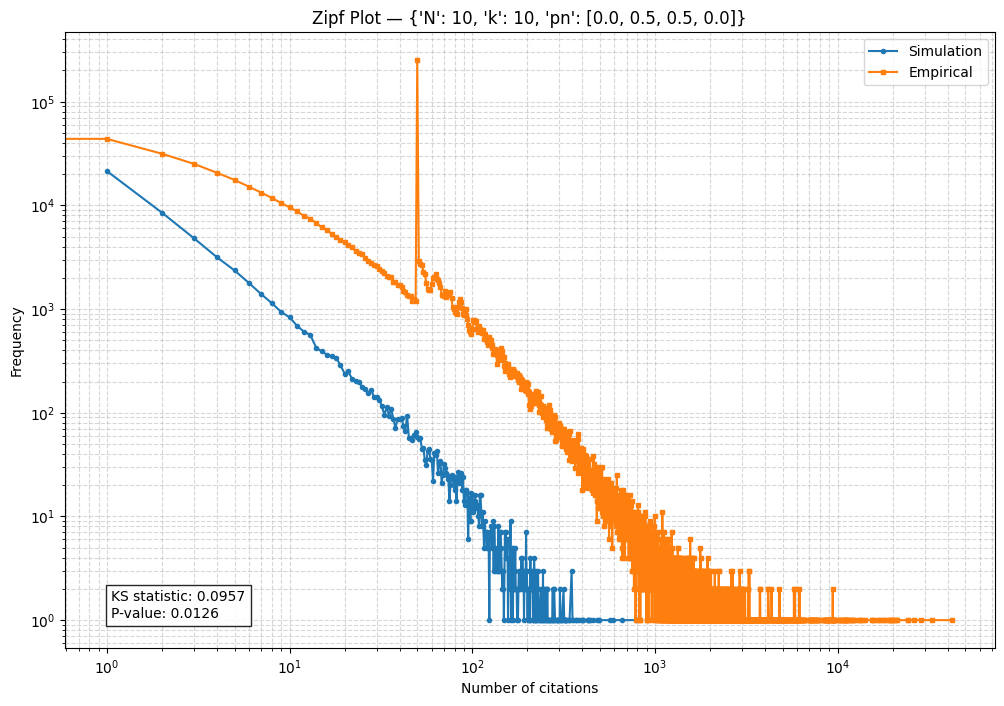

In [11]:
# 5. Wizualizacja wybranego przypadku
best_row = top_results.iloc[0]
plot_zipf_comparison(best_row['dist_cit'], reference_dist, str(best_row['settings']), best_row['KS_Stat'], best_row['P_Val'])

In [12]:
# 6. Opcjonalne: Generowanie pełnego raportu do PDF
generate_report_pdf(results_df, reference_dist, 'reports/figures/final_report.pdf')

### Run raport generation

In [ ]:
# ============================================================
# Configuration / Paths
# ============================================================

DATA_INTERIM_DIR = "data/interim"
DATA_PROCESSED_DIR = "data/processed"
REPORTS_DIR = "reports"

METADATA_PATH = f"{DATA_INTERIM_DIR}/articles_with_score_df.csv"
EMPIRICAL_REF_PATH = f"{DATA_PROCESSED_DIR}/empirical_reference_dist.json"
FINAL_DISTRIBUTIONS_PATH = f"{DATA_PROCESSED_DIR}/final_citation_distributions.csv"
FINAL_RANKING_PATH = f"{DATA_PROCESSED_DIR}/final_simulation_ranking.csv"

# Dual reporting paths
VERIFY_PDF_PATH = f"{REPORTS_DIR}/impact_verification_report.pdf"
VALIDATE_PDF_PATH = f"{REPORTS_DIR}/powerlaw_validation_report.pdf"


# ============================================================
# Notebook utilities
# ============================================================

%load_ext autoreload
%autoreload 2


# ============================================================
# Imports
# ============================================================

import os
import json
import pandas as pd
from tqdm.auto import tqdm
from matplotlib.backends.backend_pdf import PdfPages
from collections import Counter
import logging

# Logic & Visualization engines
from src.visualization.scientometrics import (
    ScientometricsAnalyzer, 
    ImpactDistributionVisualizer, 
    PowerLawAnalyticalVisualizer
)


# ============================================================
# Logging configuration
# ============================================================

# Silence powerlaw logs to prevent UI disruption
logging.getLogger("powerlaw").setLevel(logging.ERROR)


# ============================================================
# Initialization
# ============================================================

analyzer = ScientometricsAnalyzer()
verifier = ImpactDistributionVisualizer()
validator = PowerLawAnalyticalVisualizer()

os.makedirs(REPORTS_DIR, exist_ok=True)


# ============================================================
# Empirical reference distribution (Baseline)
# ============================================================

if os.path.exists(EMPIRICAL_REF_PATH):
    with open(EMPIRICAL_REF_PATH, "r") as f:
        # JSON keys are always strings, ensure integer conversion
        ref_cit_dist = {int(k): v for k, v in json.load(f).items()}
else:
    print("Generating empirical reference distribution from metadata...")
    df_meta = pd.read_csv(METADATA_PATH)
    # Ensure standard Python ints for JSON compatibility (fixes np.int64 issue)
    raw_counts = Counter(df_meta.n_citation.values)
    ref_cit_dist = {int(k): int(v) for k, v in raw_counts.items()}
    
    with open(EMPIRICAL_REF_PATH, "w") as f:
        json.dump(ref_cit_dist, f)

# Pre-calculate reference Power Law fit once for the entire batch
fit_ref = analyzer.get_powerlaw_fit(ref_cit_dist)


# ============================================================
# Load simulation results
# ============================================================

df_final = pd.read_csv(FINAL_DISTRIBUTIONS_PATH)
stats_summary = []

print(f"Generating diagnostic reports for {len(df_final)} configurations...")


# ============================================================
# Dual-Stage Report Generation
# ============================================================

with PdfPages(VERIFY_PDF_PATH) as pdf_v, PdfPages(VALIDATE_PDF_PATH) as pdf_a:
    for idx, row in tqdm(
        df_final.iterrows(),
        total=len(df_final),
        desc="Rendering Diagnostics"
    ):
        # 1. ANALYZE (Pure logic)
        exp_dist = analyzer.robust_load(row["citation_distribution"])
        exp_dist = {int(k): v for k, v in exp_dist.items()}
        settings = analyzer.robust_load(row["settings"])
        
        ks_val = analyzer.calculate_ks(exp_dist, ref_cit_dist)
        fit_exp = analyzer.get_powerlaw_fit(exp_dist)
        
        config_label = f"ID: {idx} | N={settings['N']}, k={settings['k']}, PN={settings['pn']}"

        # 2. VISUALIZE Stage 1: Empirical Verification
        verifier.plot_page(exp_dist, ref_cit_dist, ks_val, config_label, pdf_v)
        
        # 3. VISUALIZE Stage 2: Power Law Validation
        validator.plot_page(fit_exp, fit_ref, ks_val, config_label, pdf_a)

        # 4. STORE RESULTS
        stats_summary.append({
            "config_id": idx,
            "ks_stat": ks_val,
            "alpha_sim": fit_exp.alpha,
            "settings": settings
        })


d:\ProgrammingLang\Python\Python314\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Generating diagnostic reports for 306 configurations...


Rendering Diagnostics: 100%|██████████| 306/306 [24:04<00:00,  4.72s/it]


In [4]:
# ============================================================
# Final ranking export
# ============================================================

rank_df = pd.DataFrame(stats_summary).sort_values("ks_stat")
rank_df.to_csv(FINAL_RANKING_PATH, index=False)

print("\nProcessing complete. Top 10 configurations by KS fitness:")
display(rank_df.head(10))


Processing complete. Top 10 configurations by KS fitness:


,config_id,ks_stat,alpha_sim,settings
172,172,0.010616,2.566810,"{'N': 100, 'k': 10, 'pn': [0.0, 0.9, 0.0, 0.1]}"
223,223,0.010616,2.379123,"{'N': 100, 'k': 25, 'pn': [0.0, 0.9, 0.0, 0.1]}"
274,274,0.010683,2.381953,"{'N': 100, 'k': 50, 'pn': [0.0, 0.9, 0.0, 0.1]}"
68,68,0.012199,2.412909,"{'N': 10, 'k': 25, 'pn': [0.0, 0.75, 0.0, 0.25]}"
173,173,0.013596,2.493415,"{'N': 100, 'k': 10, 'pn': [0.0, 0.9, 0.1, 0.0]}"
224,224,0.014015,2.516827,"{'N': 100, 'k': 25, 'pn': [0.0, 0.9, 0.1, 0.0]}"
275,275,0.014351,2.507775,"{'N': 100, 'k': 50, 'pn': [0.0, 0.9, 0.1, 0.0]}"
119,119,0.024071,2.378751,"{'N': 10, 'k': 50, 'pn': [0.0, 0.75, 0.0, 0.25]}"
32,32,0.026607,2.198216,"{'N': 10, 'k': 10, 'pn': [0.25, 0.5, 0.0, 0.25]}"
17,17,0.027209,2.284687,"{'N': 10, 'k': 10, 'pn': [0.0, 0.75, 0.0, 0.25]}"
